In [2]:
#!/bin/bash
!curl -L -o libri-noise-dataset.zip https://www.kaggle.com/api/v1/datasets/download/earth16/libri-speech-noise-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6178M  100 6178M    0     0   205M      0  0:00:30  0:00:30 --:--:--  226M


In [3]:
!unzip -q libri-noise-dataset.zip

In [4]:
!rm -rf BWAVN.7z epoc-27-results.xltx LibriNoise_Train_Test_NPY ModelArchitecture.txt model.h5.png noisesB.7z NoiseTest.pptx NoiseTest_SNR.pptx results.7z

In [5]:
!7z x train.7z -onoisy > /dev/null

In [6]:
!7z x y_train.7z -odenoised > /dev/null

In [7]:
!7z x test.7z -onoisy > /dev/null
!7z x y_test.7z -odenoised > /dev/null

In [1]:
import librosa
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio, IFrame, display
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
!ls noisy/train/103-1240-0005.wav

noisy/train/103-1240-0005.wav


In [3]:
!ls denoised/

y_test	y_train


In [4]:
train_noisy_files = sorted(glob.glob('noisy/train/*.wav'))
train_clear_files = sorted(glob.glob('denoised/y_train/*.wav'))
assert len(train_clear_files) == len(train_noisy_files)

In [5]:
train_noisy_files[0], train_clear_files[0]

('noisy/train/103-1240-0005.wav', 'denoised/y_train/103-1240-0005.wav')

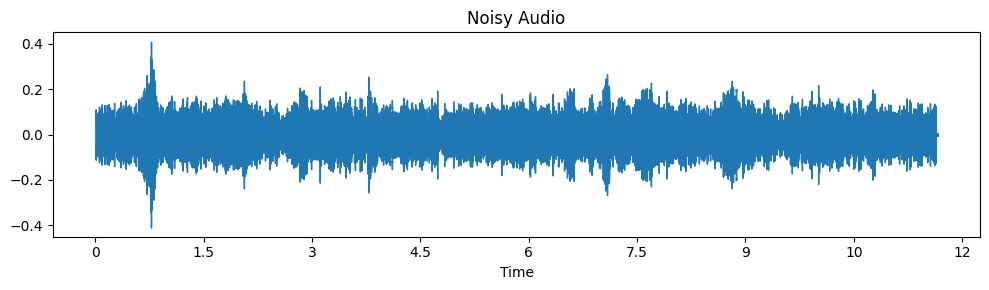

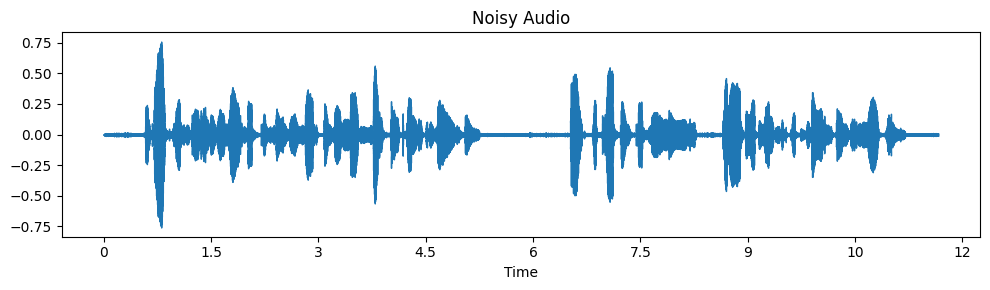

In [6]:
sr = 16000

idx = 1000

x, sr = librosa.load(train_noisy_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(x,rate=sr))

y, sr = librosa.load(train_clear_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(y,rate=sr))

In [7]:
import glob
import librosa
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import random

class MyDataset(Dataset):
    def __init__(self, noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', ind=None, need_crop=False, cnt_seconds=16, need_all=False, single_file_path=None):
        if (single_file_path is not None):
            self.noisy_files = [single_file_path]
            self.clear_files = [single_file_path]
        else:
            self.noisy_files = np.array(sorted(glob.glob(noisy_folder + '*.wav')))
            self.clear_files = np.array(sorted(glob.glob(denoised_folder + '*.wav')))
        # print(len(self.clear_files))

        assert len(self.noisy_files) == len(self.clear_files)
        for f, s in zip(self.noisy_files, self.clear_files):
            assert f.split('/')[-1] == s.split('/')[-1]

        if ind is not None:
            self.noisy_files = self.noisy_files[ind]
            self.clear_files = self.clear_files[ind]
        self.cnt_seconds = cnt_seconds
        self.sr = 16000
        self.need_crop = need_crop
        self.need_all = need_all
            
    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        need_size = self.cnt_seconds * self.sr
        
        noisy_file = self.noisy_files[idx]
        clear_file = self.clear_files[idx]

        noisy_arr, _ = librosa.load(noisy_file, mono=True, sr=self.sr, offset=0)
        clear_arr, _ = librosa.load(clear_file, mono=True, sr=self.sr, offset=0)

        noisy_arr = torch.tensor(noisy_arr, dtype=torch.float)
        clear_arr = torch.tensor(clear_arr, dtype=torch.float)

        

        if self.need_all:
            noisy_segments = []
            clear_segments = []

            num_segments = max(len(noisy_arr) // need_size, 1)
            for i in range(num_segments):
                start = i * need_size
                noisy_segments.append(noisy_arr[start:start + need_size])
                clear_segments.append(clear_arr[start:start + need_size])

            noisy_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in noisy_segments]
            clear_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in clear_segments]

            
            return (torch.stack(noisy_segments).unsqueeze(1), torch.stack(clear_segments).unsqueeze(1))

        if not self.need_crop:
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))
        else:
            l = random.randint(0, max(1, noisy_arr.shape[0] - need_size))
            r = min(l + need_size, noisy_arr.shape[0])
            noisy_arr = noisy_arr[l:r]
            clear_arr = clear_arr[l:r]
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))

        assert noisy_arr.shape == clear_arr.shape

        noisy_arr = noisy_arr.unsqueeze(0)
        clear_arr = clear_arr.unsqueeze(0)

        return (noisy_arr, clear_arr)


In [8]:

n_total = 7000
cnt_valid = 400
all_indices = list(range(n_total))

random.seed(42)
random.shuffle(all_indices)
valid_indices = np.array(all_indices[:cnt_valid])
train_indices = np.array(all_indices[cnt_valid:])

train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=3, need_all=False, ind=train_indices)
valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=3, need_all=True, ind=valid_indices)
test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=3, need_all=True)

In [9]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6600, 400, 105)

In [10]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [11]:
train_dataset[0][0].shape

torch.Size([1, 48000])

In [12]:
class UModel(nn.Module):
    def make_ds_block(self, idx):
        in_channels = (1 if idx == 1 else self.F_c*(idx-1))
        out_channels = self.F_c * idx
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=self.f_d, padding=self.f_d//2),
            nn.BatchNorm1d(out_channels),
            nn.MaxPool1d(kernel_size=2),
            nn.LeakyReLU(0.2),
        )

    def make_us_block(self, idx):
        in_channels = self.F_c * idx * 2
        
        out_channels = self.F_c * idx
        
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def __init__(self, L, F_c, f_d, f_u, k):
        super().__init__()
        self.L = L
        self.F_c = F_c
        self.f_d = f_d
        self.f_u = f_u
        self.k = k
        
        self.ds_blocks = []
        for i in range(1, L + 1):
            self.ds_blocks.append(self.make_ds_block(i))

        self.back_bone = nn.Conv1d(self.F_c*L, self.F_c*(L+1), kernel_size=self.f_d, padding=self.f_d//2)


        self.us_blocks = [None] * L
        for i in range(1, L + 1, 1):
             self.us_blocks[i - 1] = self.make_us_block(i)

        self.conv1d_blocks = [None] * L
        for i in range(1, L + 1, 1):
            in_channels = self.F_c*(i+1)
            out_channels = self.F_c*i
            self.conv1d_blocks[i - 1] = nn.Conv1d(in_channels, out_channels, kernel_size=1)
            
        self.ds_blocks = nn.ModuleList(self.ds_blocks)
        self.us_blocks = nn.ModuleList(self.us_blocks)
        self.conv1d_blocks = nn.ModuleList(self.conv1d_blocks)

        self.Final_block = nn.Sequential(
            nn.Conv1d(self.F_c + 1, self.k, kernel_size=1, padding=0),
            nn.BatchNorm1d(self.k),
            nn.Tanh(),
        )

    def forward(self, X):
        
        ds_tensors = []
        ds_tensors.append(X)
        for i in range(1, self.L + 1):
            X = self.ds_blocks[i - 1](X)
            ds_tensors.append(X)

        X = self.back_bone(X)
        for i in range(self.L, 0, -1):
            if (i < self.L):
                cur_X = F.interpolate(X, scale_factor=2, mode='linear') # B x self.F_c*(idx+1) x n_f
            else:
                cur_X = X
            # print(cur_X.shape, ds_tensors[i - 1].shape)
            # print(i, cur_X.shape)
            cur_X = self.conv1d_blocks[i - 1](cur_X)
            skip = ds_tensors[i]
            # print(i, cur_X.shape, skip.shape)

            len_cur = cur_X.size(-1)
            len_skip = skip.size(-1)
            if len_cur < len_skip:
                cur_X = F.pad(cur_X, (0, len_skip - len_cur))
            elif len_cur > len_skip:
                cur_X = cur_X[..., :len_skip]
        
                
            new_X = torch.concat((cur_X, skip), dim=1)
            # print(new_X.shape)
            X = self.us_blocks[i - 1](new_X)

        X = F.interpolate(X, scale_factor=2, mode='linear')
        # print(X.shape, self.conv1d_blocks[0])
        new_X = torch.concat((X, ds_tensors[0]), dim=1)
        X = self.Final_block(new_X)
        return X

# model = UModel(L=10, F_c=24, f_d=15, f_u=5, k=10)

In [13]:
# for cur,_ in train_dataloader:
#     print(cur.shape)
#     # cur = cur.unsqueeze(0)
#     cur_ans = model(cur)
#     print(cur_ans.shape)
#     break

In [14]:
!pip install asteroid

In [15]:
!pip install pesq

In [16]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
from pesq import pesq

2025-07-13 14:43:12.287260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752417792.310336     194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752417792.317411     194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
from torchmetrics.audio import PerceptualEvaluationSpeechQuality

In [18]:
def calculate_batch_SI_SDR(preds_batch, y_batch, SI_SDR_metric):
    sum_metric = 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        try:
            cur = SI_SDR_metric(cur_pred, cur_y)
            sum_metric += cur
        except:
            continue
    return sum_metric / len(preds_batch)

def calculate_batch_PESQ(preds_batch, y_batch, fs=16000, mode='wb'):
    total, count = 0.0, 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        ref = cur_y.squeeze(0).detach().cpu().numpy()
        deg = cur_pred.squeeze(0).detach().cpu().numpy()

        try:
            score = pesq(fs, ref=ref, deg=deg, mode=mode)
            total += score
            count += 1
        except:
            continue

    return total / count if count > 0 else 0.0

In [19]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

def train(model, criterion, train_dataloader, valid_dataset, optimizer, epochs, device, metrics):
    best_sdr = -1e6
    best_loss = 1e6

    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True, 
    ).to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0        

        cnt_steps_train = len(train_dataloader)
        for batch_x, batch_y in tqdm(train_dataloader):

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_loss += loss.item()


        train_loss /= cnt_steps_train
        print(f'Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f}')

        metrics['train_loss'].append(train_loss)
        
        model.eval()
        valid_loss = 0
        valid_sdr = 0
        # valid_pesq = 0
        with torch.no_grad():
            for batch_x, batch_y in tqdm(valid_dataset):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                # print(batch_x.shape, batch_y.shape)
                
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                valid_loss += loss.item()
                
                valid_sdr += SI_SDR_metric(preds, batch_y)
                
                # valid_pesq += calculate_batch_PESQ(preds, batch_y)
                
        valid_loss /= len(valid_dataset)
        valid_sdr /= len(valid_dataset)
        # valid_pesq /= len(valid_dataset)
        

        print(f'Epoch {epoch}/{epochs} | Valid Loss: {valid_loss:.6f} | Valid SI-SDR: {valid_sdr:.4f}')
        
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_si_sdr'].append(valid_sdr)
        # metrics['valid_pesq'].append(valid_pesq)

        if valid_sdr > best_sdr:
            best_sdr = valid_sdr
            sdr_model = model
        if valid_loss < best_loss:
            best_loss = valid_loss
            loss_model = model
            
    return sdr_model, loss_model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UModel(L=10, F_c=24, f_d=15, f_u=5, k=1).to(device)
model = UModel(L=12, F_c=24, f_d=15, f_u=5, k=1).to(device)

model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'])
# criterion = nn.MSELoss()

metrics = {
    'train_loss': [],
    'train_si_sdr': [],
    'train_pesq': [],
    'valid_loss': [],
    'valid_si_sdr': [],
    'valid_pesq': []
}


In [21]:
from asteroid.losses import SingleSrcPMSQE

In [22]:
def si_sdr_loss(pred, ref, eps=1e-8):
    # pred/ref shape: [B, 1, T]
    ref_energy = torch.sum(ref**2, dim=-1, keepdim=True) + eps
    proj = torch.sum(pred * ref, dim=-1, keepdim=True) * ref / ref_energy
    
    noise = pred - proj

    num = torch.sum(proj**2, dim=-1)
    den = torch.sum(noise**2, dim=-1)
    ratio = num / (den + eps)
    ratio = torch.clamp(ratio, min=eps)
    sisd = 10 * torch.log10(ratio)
    return -sisd.mean()


class SI_SDR_PESQ_Loss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.pmsqe = SingleSrcPMSQE(sample_rate=16000).to(device)
        self.si_sdr_loss = si_sdr_loss
        
        self.n_fft = 512
        self.win_length = 512
        self.hop_length = 128
        self.window = torch.hann_window(self.win_length)

    def forward(self, preds, target):
        sdr_loss = self.si_sdr_loss(preds, target)

        preds1 = preds.squeeze(1) 
        target1 = target.squeeze(1)

        window = self.window.to(preds1.device)

        def mag_stft(x):
            stft = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length,
                              win_length=self.win_length, window=window,
                              return_complex=True)
            return torch.abs(stft) 

        preds_mag = mag_stft(preds1)
        target_mag = mag_stft(target1)

        pmsqe_loss = self.pmsqe(preds_mag, target_mag).mean()
        return sdr_loss + self.alpha * pmsqe_loss


criterion = SI_SDR_PESQ_Loss(0.7)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 15, device, metrics)

100%|██████████| 104/104 [01:28<00:00,  1.18it/s]


Epoch 1/15 | Train Loss: 3.241352


100%|██████████| 400/400 [00:24<00:00, 16.02it/s]


Epoch 1/15 | Valid Loss: 1.540890 | Valid SI-SDR: 0.0641


100%|██████████| 104/104 [01:37<00:00,  1.06it/s]


Epoch 2/15 | Train Loss: 0.361130


100%|██████████| 400/400 [00:25<00:00, 15.93it/s]


Epoch 2/15 | Valid Loss: -0.584724 | Valid SI-SDR: 2.1988


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 3/15 | Train Loss: -1.343427


100%|██████████| 400/400 [00:24<00:00, 16.19it/s]


Epoch 3/15 | Valid Loss: -0.675894 | Valid SI-SDR: 2.4022


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 4/15 | Train Loss: -2.186208


100%|██████████| 400/400 [00:25<00:00, 15.94it/s]


Epoch 4/15 | Valid Loss: -2.787087 | Valid SI-SDR: 4.3619


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 5/15 | Train Loss: -2.316763


100%|██████████| 400/400 [00:24<00:00, 16.62it/s]


Epoch 5/15 | Valid Loss: -3.196739 | Valid SI-SDR: 4.7090


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 6/15 | Train Loss: -2.934635


100%|██████████| 400/400 [00:24<00:00, 16.31it/s]


Epoch 6/15 | Valid Loss: 0.375631 | Valid SI-SDR: 1.1708


100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


Epoch 7/15 | Train Loss: -3.020230


100%|██████████| 400/400 [00:24<00:00, 16.10it/s]


Epoch 7/15 | Valid Loss: -0.691441 | Valid SI-SDR: 2.2884


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 8/15 | Train Loss: -2.061140


100%|██████████| 400/400 [00:24<00:00, 16.53it/s]


Epoch 8/15 | Valid Loss: -3.141007 | Valid SI-SDR: 4.6165


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 9/15 | Train Loss: -2.959617


100%|██████████| 400/400 [00:24<00:00, 16.58it/s]


Epoch 9/15 | Valid Loss: -1.426348 | Valid SI-SDR: 2.9614


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 10/15 | Train Loss: -3.038282


100%|██████████| 400/400 [00:24<00:00, 16.46it/s]


Epoch 10/15 | Valid Loss: -3.146661 | Valid SI-SDR: 4.5943


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 11/15 | Train Loss: -3.287453


100%|██████████| 400/400 [00:24<00:00, 16.38it/s]


Epoch 11/15 | Valid Loss: -2.586112 | Valid SI-SDR: 4.2283


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 12/15 | Train Loss: -3.444016


100%|██████████| 400/400 [00:24<00:00, 16.23it/s]


Epoch 12/15 | Valid Loss: -3.553610 | Valid SI-SDR: 5.0078


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 13/15 | Train Loss: -3.872125


100%|██████████| 400/400 [00:24<00:00, 16.18it/s]


Epoch 13/15 | Valid Loss: -4.060541 | Valid SI-SDR: 5.5341


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 14/15 | Train Loss: -3.968560


100%|██████████| 400/400 [00:24<00:00, 16.56it/s]


Epoch 14/15 | Valid Loss: -4.541009 | Valid SI-SDR: 5.9547


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 15/15 | Train Loss: -4.355958


100%|██████████| 400/400 [00:23<00:00, 16.82it/s]

Epoch 15/15 | Valid Loss: -5.019705 | Valid SI-SDR: 6.4040


In [25]:
model = best_loss

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 15, device, metrics)

100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 1/15 | Train Loss: -4.407292


100%|██████████| 400/400 [00:24<00:00, 16.53it/s]


Epoch 1/15 | Valid Loss: -5.098658 | Valid SI-SDR: 6.5257


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 2/15 | Train Loss: -4.928794


100%|██████████| 400/400 [00:23<00:00, 16.70it/s]


Epoch 2/15 | Valid Loss: -5.017066 | Valid SI-SDR: 6.5286


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 3/15 | Train Loss: -5.095866


100%|██████████| 400/400 [00:24<00:00, 16.46it/s]


Epoch 3/15 | Valid Loss: -5.377311 | Valid SI-SDR: 6.8604


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 4/15 | Train Loss: -5.367501


100%|██████████| 400/400 [00:24<00:00, 16.45it/s]


Epoch 4/15 | Valid Loss: -5.657011 | Valid SI-SDR: 7.0768


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 5/15 | Train Loss: -5.495509


100%|██████████| 400/400 [00:25<00:00, 15.98it/s]


Epoch 5/15 | Valid Loss: -5.444579 | Valid SI-SDR: 6.8369


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 6/15 | Train Loss: -5.683225


100%|██████████| 400/400 [00:24<00:00, 16.53it/s]


Epoch 6/15 | Valid Loss: -5.176078 | Valid SI-SDR: 6.6170


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 7/15 | Train Loss: -5.794287


100%|██████████| 400/400 [00:24<00:00, 16.48it/s]


Epoch 7/15 | Valid Loss: -5.903586 | Valid SI-SDR: 7.2234


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 8/15 | Train Loss: -5.968832


100%|██████████| 400/400 [00:25<00:00, 16.00it/s]


Epoch 8/15 | Valid Loss: -5.043876 | Valid SI-SDR: 6.3896


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 9/15 | Train Loss: -5.690945


100%|██████████| 400/400 [00:24<00:00, 16.42it/s]


Epoch 9/15 | Valid Loss: -6.478557 | Valid SI-SDR: 7.7249


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 10/15 | Train Loss: -6.185950


100%|██████████| 400/400 [00:24<00:00, 16.25it/s]


Epoch 10/15 | Valid Loss: -6.138623 | Valid SI-SDR: 7.3656


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 11/15 | Train Loss: -6.328203


100%|██████████| 400/400 [00:24<00:00, 16.16it/s]


Epoch 11/15 | Valid Loss: -6.476133 | Valid SI-SDR: 7.7608


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 12/15 | Train Loss: -6.455661


100%|██████████| 400/400 [00:23<00:00, 16.70it/s]


Epoch 12/15 | Valid Loss: -6.409284 | Valid SI-SDR: 7.6331


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 13/15 | Train Loss: -6.525142


100%|██████████| 400/400 [00:24<00:00, 16.25it/s]


Epoch 13/15 | Valid Loss: -6.546798 | Valid SI-SDR: 7.7840


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 14/15 | Train Loss: -6.622320


100%|██████████| 400/400 [00:24<00:00, 16.26it/s]


Epoch 14/15 | Valid Loss: -6.781069 | Valid SI-SDR: 8.0059


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 15/15 | Train Loss: -6.662019


100%|██████████| 400/400 [00:24<00:00, 16.55it/s]

Epoch 15/15 | Valid Loss: -7.108806 | Valid SI-SDR: 8.3024


In [28]:
import copy
tmp_model = copy.deepcopy(best_loss)

In [29]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 5, device, metrics)

100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 1/5 | Train Loss: -6.775589


100%|██████████| 400/400 [00:24<00:00, 16.48it/s]


Epoch 1/5 | Valid Loss: -6.012435 | Valid SI-SDR: 7.2403


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 2/5 | Train Loss: -6.721089


100%|██████████| 400/400 [00:24<00:00, 16.11it/s]


Epoch 2/5 | Valid Loss: -6.762965 | Valid SI-SDR: 7.9755


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 3/5 | Train Loss: -6.584304


100%|██████████| 400/400 [00:24<00:00, 16.54it/s]


Epoch 3/5 | Valid Loss: -7.095396 | Valid SI-SDR: 8.2851


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 4/5 | Train Loss: -6.894824


100%|██████████| 400/400 [00:23<00:00, 16.72it/s]


Epoch 4/5 | Valid Loss: -7.309921 | Valid SI-SDR: 8.4876


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 5/5 | Train Loss: -6.995224


100%|██████████| 400/400 [00:24<00:00, 16.34it/s]

Epoch 5/5 | Valid Loss: -7.206651 | Valid SI-SDR: 8.4147


In [30]:
model = best_loss

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [32]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 10, device, metrics)

100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 1/10 | Train Loss: -7.191966


100%|██████████| 400/400 [00:24<00:00, 16.45it/s]


Epoch 1/10 | Valid Loss: -7.610783 | Valid SI-SDR: 8.7736


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 2/10 | Train Loss: -7.274611


100%|██████████| 400/400 [00:23<00:00, 16.76it/s]


Epoch 2/10 | Valid Loss: -7.681551 | Valid SI-SDR: 8.8262


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 3/10 | Train Loss: -7.244029


100%|██████████| 400/400 [00:24<00:00, 16.43it/s]


Epoch 3/10 | Valid Loss: -7.633135 | Valid SI-SDR: 8.7660


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 4/10 | Train Loss: -7.311147


100%|██████████| 400/400 [00:24<00:00, 16.28it/s]


Epoch 4/10 | Valid Loss: -7.743715 | Valid SI-SDR: 8.8736


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 5/10 | Train Loss: -7.368549


100%|██████████| 400/400 [00:24<00:00, 16.20it/s]


Epoch 5/10 | Valid Loss: -7.575315 | Valid SI-SDR: 8.7645


100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


Epoch 6/10 | Train Loss: -7.395000


100%|██████████| 400/400 [00:24<00:00, 16.26it/s]


Epoch 6/10 | Valid Loss: -7.564294 | Valid SI-SDR: 8.7043


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 7/10 | Train Loss: -7.414667


100%|██████████| 400/400 [00:23<00:00, 16.71it/s]


Epoch 7/10 | Valid Loss: -7.792046 | Valid SI-SDR: 8.9294


100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


Epoch 8/10 | Train Loss: -7.462087


100%|██████████| 400/400 [00:24<00:00, 16.16it/s]


Epoch 8/10 | Valid Loss: -7.875762 | Valid SI-SDR: 9.0063


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 9/10 | Train Loss: -7.487752


100%|██████████| 400/400 [00:24<00:00, 16.26it/s]


Epoch 9/10 | Valid Loss: -7.910271 | Valid SI-SDR: 9.0188


100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


Epoch 10/10 | Train Loss: -7.556857


100%|██████████| 400/400 [00:24<00:00, 16.08it/s]

Epoch 10/10 | Valid Loss: -7.908414 | Valid SI-SDR: 9.0247


In [33]:
model = best_loss

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 10))

    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['valid_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics['valid_si_sdr'], label='Validation SI-SDR', marker='o')
    plt.title('Training and Validation SDR')
    plt.xlabel('Epochs')
    plt.ylabel('SI-SDR')
    plt.legend()
    plt.grid()



    plt.tight_layout()
    plt.show()


In [38]:
# metrics['train_si_sdr'] = [cur.item() for cur in metrics['train_si_sdr']]
metrics['valid_si_sdr'] = [cur.item() for cur in metrics['valid_si_sdr']]

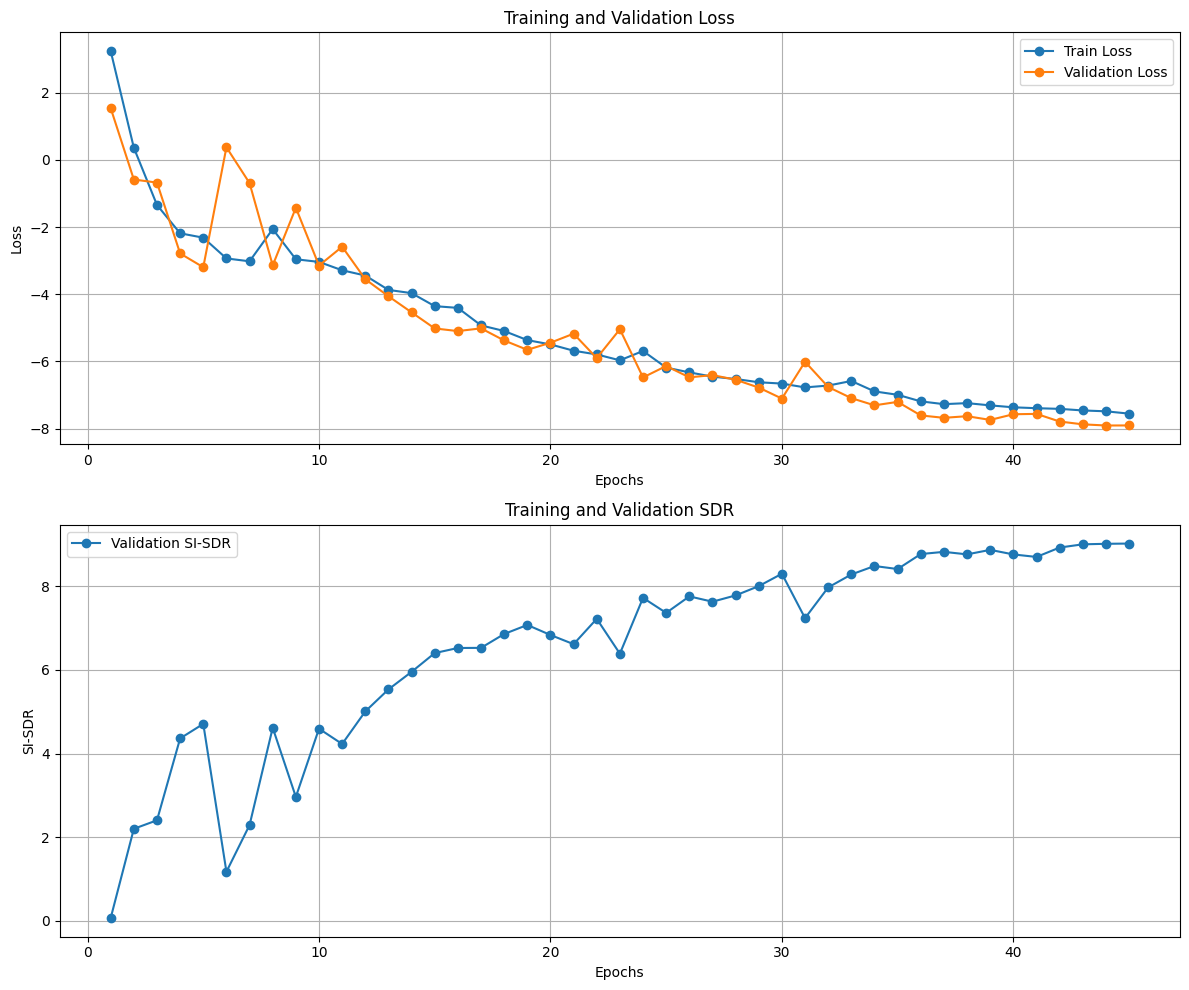

In [39]:
plot_metrics(metrics)

In [50]:
model = best_loss

In [40]:
def evaluate_test(model, test_dataset, device, criterion):
    model.eval()
    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True,  
    ).to(device)
    loss = 0
    si_sdr = 0
    pesq = 0
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dataset):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)

            loss += criterion(preds, batch_y)
            si_sdr += SI_SDR_metric(preds, batch_y)
            pesq += calculate_batch_PESQ(preds, batch_y)
    loss /= len(test_dataset)
    si_sdr /= len(test_dataset)
    pesq /= len(test_dataset)
    print(f'Test Loss: {loss}, Test SI-SDR: {si_sdr}, Test PESQ: {pesq}')

In [41]:
def denoise_file(path, model, device):
    sr = 16000
    noise_arr,_ = librosa.load(path, mono=True, sr=sr, offset=0, duration=16)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(noise_arr, sr=sr, axis='time')
    plt.title("Noisy Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(noise_arr,rate=sr))

    with torch.no_grad():
        cur_dataset = MyDataset(need_crop=True, cnt_seconds=2, need_all=True, single_file_path=path)
        
        clear_audio = model(cur_dataset[0][0]).detach().cpu().numpy()
        clear_audio = clear_audio.reshape(-1)
    # print(clear_audio.shape)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(clear_audio, sr=sr, axis='time')
    plt.title("Clear Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(clear_audio,rate=sr))

In [42]:
evaluate_test(model, test_dataset, device, criterion)

100%|██████████| 105/105 [01:02<00:00,  1.67it/s]

Test Loss: -7.4072041511535645, Test SI-SDR: 8.480247497558594, Test PESQ: 1.4842217170151453


In [43]:
torch.save(model.module.state_dict(), 'model_si-sdr_pesq_07.pt')

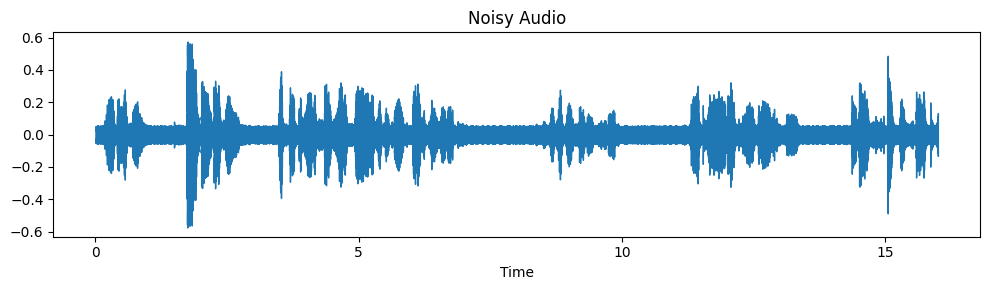

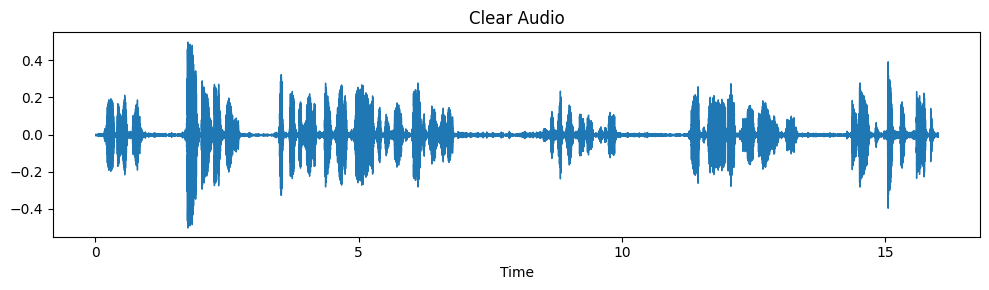

In [44]:
denoise_file('noisy/test/1034-121119-0049.wav', model, device)

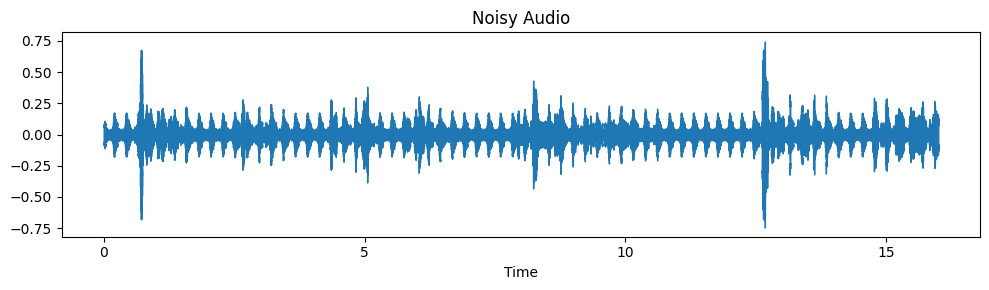

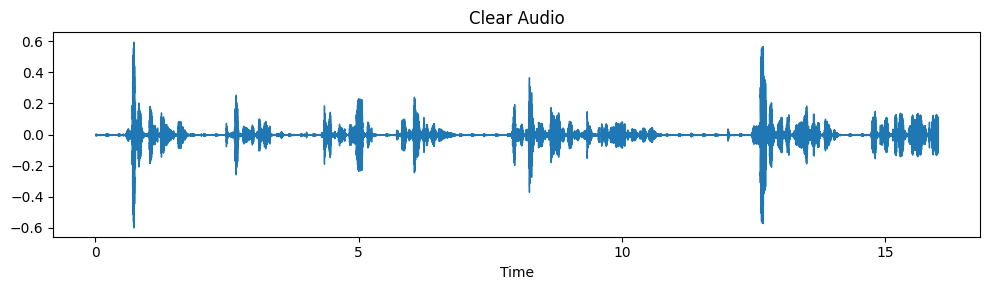

In [45]:
denoise_file('noisy/test/1040-133433-0080.wav', model, device)

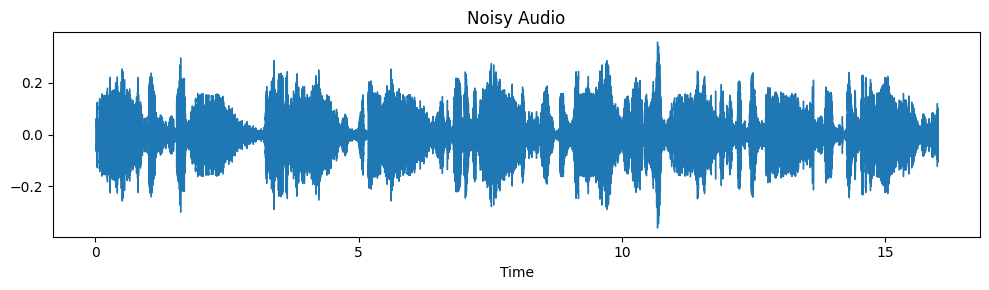

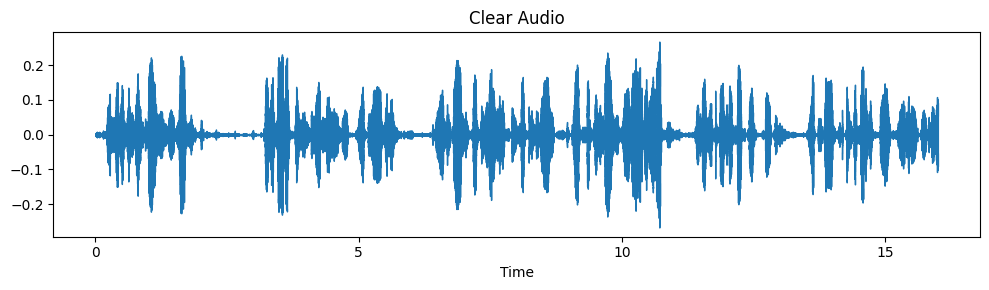

In [46]:
denoise_file('noisy/test/1081-125237-0053.wav', model, device)

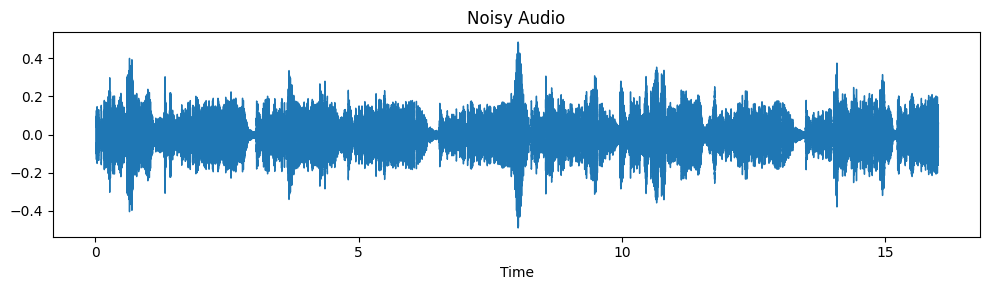

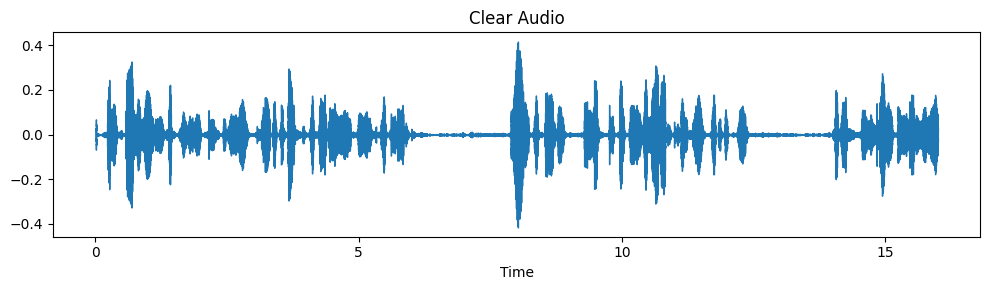

In [47]:
denoise_file('noisy/test/226-131532-0003.wav', model, device)

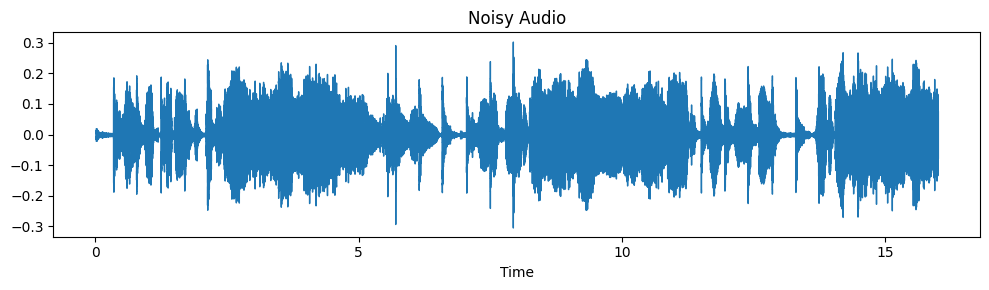

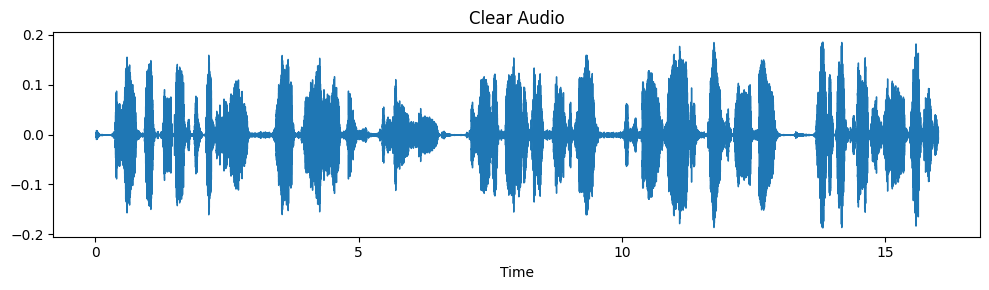

In [48]:
denoise_file('noisy/test/6848-252323-0032.wav', model, device)

In [50]:
!rm -rf denoised libri-noise-dataset.zip noisy samples.7z test.7z train.7z y_test.7z y_train.7z

In [51]:
!ls

model_si-sdr_pesq_07.pt
